In [117]:
!pip install openai


In [ ]:
# ===================================================   GPT 4o Evaluation   ====================================================

In [1]:
import os
import pandas as pd
import openai
from tqdm import tqdm

# 1. הגדרת משתני הסביבה בתוך ה־Notebook
os.environ["AZURE_OPENAI_ENDPOINT"]   = (
    "https://glebl-mbdogv74-eastus2."
    "cognitiveservices.azure.com/"
    "openai/deployments/gpt-4o/"
    "chat/completions?api-version=2025-01-01-preview"
)
os.environ["AZURE_OPENAI_KEY"]        = "1PA2KoUiSGqPCfLfJPzbseJMSxHYNcboP3YOX7oMNdb5XjRzuJx1JQQJ99BFACHYHv6XJ3w3AAAAACOGi51o"
os.environ["AZURE_OPENAI_DEPLOYMENT"] = "gpt-4o"

# 2. מספר התגובות לעיבוד (התחל עם 5; שנה ל-3500 כשיוודא שהכל תקין)
EXAMPLES = 3500

# 3. נתיב לקובץ הלא מתוייג
DATA_PATH = r"C:\Users\Gleb\Desktop\N.L.P\CHATGPT_DATASET_NOT_LABELED.csv"

# 4. קריאת הקובץ ל-DataFrame (UTF-8 ואחריה Latin1 במידת הצורך)
try:
    df = pd.read_csv(DATA_PATH, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(DATA_PATH, encoding="latin1")

# 5. בחירת EXAMPLES השורות הראשונות
df_subset = df.head(EXAMPLES).copy()

# 6. יצירת עמודות ריקות לתיוג
df_subset['difficulty'] = None
df_subset['interest'] = None
df_subset['usefulness'] = None
df_subset['teaching_quality'] = None

# 7. קריאת ערכי משתני הסביבה
endpoint   = os.getenv("AZURE_OPENAI_ENDPOINT")
api_key    = os.getenv("AZURE_OPENAI_KEY")
deployment = os.getenv("AZURE_OPENAI_DEPLOYMENT")

# 8. קונפיגורציה של openai לקריאה דרך Azure
openai.api_type    = "azure"
openai.api_base    = endpoint.split("/openai")[0]
openai.api_version = endpoint.split("api-version=")[1]
openai.api_key     = api_key

# 9. פונקציה לתיוג תגובה יחידה בארבעה לייבלים (0–3)
def classify_feedback(review_text):
    prompt = f"""הערך את התגובה הבאה בנוגע לקורס על פי ארבעה מדדים (מספר בין 0 ל-3):
1. קושי הקורס (0 = לא מתייחס, 1 = הקורס קל, 2 = רמת קושי בינונית, 3 = הקורס קשה)
2. רמת העניין (0 = לא מתייחס, 1 = הקורס לא מעניין, 2 = רמת עניין בינונית, 3 = הקורס מאוד מעניין)
3. רמת המועילות (0 = לא מתייחס, 1 = הקורס לא מועיל, 2 = מועילות ממוצעת, 3 = מועילות גבוהה)
4. רמת ההוראה (0 = לא מתייחס, 1 = רמת הוראה נמוכה, 2 = רמת הוראה בינונית, 3 = רמת הוראה גבוהה)

תגובה: "{review_text}"

מספרי פלט רק את ארבעת המספרים בסדר הנ"ל, מופרדים בפסיק, ללא טקסט נוסף."""
    try:
        response = openai.chat.completions.create(
            model=deployment,
            messages=[
                {"role": "system", "content": "אתה עוזר לנתח תגובות תלמידים."},
                {"role": "user",   "content": prompt}
            ],
            max_tokens=20,
            temperature=0
        )
        content = response.choices[0].message.content.strip()
        scores = [int(x) for x in content.split(",")]
        return scores
    except Exception:
        return [None, None, None, None]

# 10. לולאה עם חיווי התקדמות ושמירה בין-מידעית (checkpointing)
BATCH_SIZE = 100
total_rows = len(df_subset)

for idx in tqdm(range(total_rows), desc="Zero-shot labeling"):
    review = df_subset.at[idx, 'review']
    difficulty, interest, usefulness, teaching_quality = classify_feedback(review)
    df_subset.at[idx, 'difficulty']       = difficulty
    df_subset.at[idx, 'interest']         = interest
    df_subset.at[idx, 'usefulness']       = usefulness
    df_subset.at[idx, 'teaching_quality'] = teaching_quality

    # every BATCH_SIZE rows, save a partial checkpoint
    if (idx + 1) % BATCH_SIZE == 0 or (idx + 1) == total_rows:
        batch_number = (idx + 1) // BATCH_SIZE
        if batch_number == 0:
            batch_number = 1
        partial_name = f"GPT4O_ZERO_SHOT_LABELING_batch_{batch_number * BATCH_SIZE}.csv"
        output_partial_path = os.path.join(os.path.dirname(DATA_PATH), partial_name)
        df_subset.to_csv(output_partial_path, index=False)
        # אופציונלי: להכניס sleep קצר כדי להימנע מ-Rate Limit
        # time.sleep(0.2)

# 11. לאחר סיום כל הלולאה, שמירת הקובץ המלא בשם הסופי
final_output = os.path.join(os.path.dirname(DATA_PATH), "GPT4O_ZERO_SHOT_LABELING.csv")
df_subset.to_csv(final_output, index=False)

# 12. הצגת חמש השורות הראשונות עם העמודות החדשות
df_subset.head()


Zero-shot labeling: 100%|██████████| 3500/3500 [23:20<00:00,  2.50it/s]


,review,difficulty,interest,usefulness,teaching_quality
0,Assignments duplicated the lectures without ad...,0,1,1,1
1,Assignments felt like busywork.,0,1,1,0
2,Assignments overshadowed the actual learning o...,3,0,1,0
3,Assignments were last-minute and poorly explai...,0,0,1,1
4,Complete waste of time.,0,1,1,1


In [ ]:
# =========================================   GPT 4o Evaluation Results Exploration   ==========================================


Zero-Shot GPT-4o predictions:

Number of reviews where GPT got all 4 labels correct:      1942 (55.3%)
Number of reviews where GPT got exactly 3 labels correct:  886 (25.2%)
Number of reviews where GPT got exactly 2 labels correct:  505 (14.4%)
Number of reviews where GPT got exactly 1 label correct:   168 (4.8%)
Number of reviews where GPT got 0 labels correct:          9 (0.3%)


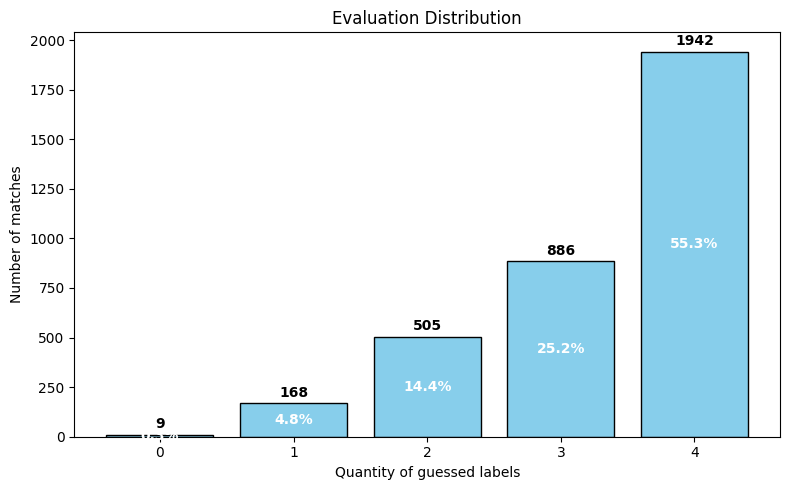

In [1]:
# ========================================
# Evaluation Results
# ========================================


import os
import pandas as pd
import matplotlib.pyplot as plt

# 1. נתיב לתיקייה המכילה את שני ה־CSV
FOLDER_PATH = r"C:\Users\Gleb\Desktop\N.L.P"

# 2. שמות הקבצים
ZERO_SHOT_FILE     = os.path.join(FOLDER_PATH, "GPT4O_ZERO_SHOT_LABELING_batch_3500.csv")
GROUND_TRUTH_FILE  = os.path.join(FOLDER_PATH, "CHATGPT_DATASET.csv")

# 3. קריאת הקבצים עם ניסיון UTF-8 ואז Latin1 במידת הצורך
try:
    df_zero = pd.read_csv(ZERO_SHOT_FILE, encoding="utf-8")
except UnicodeDecodeError:
    df_zero = pd.read_csv(ZERO_SHOT_FILE, encoding="latin1")

try:
    df_true = pd.read_csv(GROUND_TRUTH_FILE, encoding="utf-8")
except UnicodeDecodeError:
    df_true = pd.read_csv(GROUND_TRUTH_FILE, encoding="latin1")

# 4. הגדרת עמודת התגובות ושמות הלייבלים
COMMENT_COLUMN = "review"
common_labels  = ["difficulty", "interest", "usefulness", "teaching_quality"]

# 5. מיזוג על בסיס עמודת 'review'
df = pd.merge(
    df_zero,
    df_true[[COMMENT_COLUMN] + common_labels],
    on=COMMENT_COLUMN,
    how="inner",
    suffixes=("_pred", "_true")
)

# 6. חישוב תאימות בלייבלים
def count_label_matches(row):
    return sum(row[f"{label}_pred"] == row[f"{label}_true"] for label in common_labels)

df["matches"] = df.apply(count_label_matches, axis=1)

# 7. ספירת הופעות לכל ערך matches (0 עד 4)
counts = df["matches"].value_counts().sort_index()

# חישוב סך כל הדוגמאות (כדי לאמוד אחוזים)
total_reviews = len(df)

# 8. הדפסת התוצאות הטקסטואלית
results = {
    "all_4":     int(counts.get(4, 0)),
    "exactly_3": int(counts.get(3, 0)),
    "exactly_2": int(counts.get(2, 0)),
    "exactly_1": int(counts.get(1, 0)),
    "exactly_0": int(counts.get(0, 0)),
}

print("\nZero-Shot GPT-4o predictions:\n")
print(f"Number of reviews where GPT got all 4 labels correct:      {results['all_4']} ({results['all_4']/total_reviews*100:.1f}%)")
print(f"Number of reviews where GPT got exactly 3 labels correct:  {results['exactly_3']} ({results['exactly_3']/total_reviews*100:.1f}%)")
print(f"Number of reviews where GPT got exactly 2 labels correct:  {results['exactly_2']} ({results['exactly_2']/total_reviews*100:.1f}%)")
print(f"Number of reviews where GPT got exactly 1 label correct:   {results['exactly_1']} ({results['exactly_1']/total_reviews*100:.1f}%)")
print(f"Number of reviews where GPT got 0 labels correct:          {results['exactly_0']} ({results['exactly_0']/total_reviews*100:.1f}%)")

# 9. יצירת היסטוגרמה באמצעות matplotlib עם הצגת מספר ואחוז מעל כל בר
plt.figure(figsize=(8, 5))
bars = plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Quantity of guessed labels')
plt.ylabel('Number of matches')
plt.title('Evaluation Distribution')
plt.xticks([0, 1, 2, 3, 4])

# הוספת טקסט עם מספר הדוגמאות (count) מעל כל בר ואחוז במרכז כל בר
for bar in bars:
    height = bar.get_height()
    percent = (height / total_reviews) * 100
    # הצגת מספר הדוגמאות מעל כל בר
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (total_reviews * 0.005),  # מעט מעל הגובה של הבר עבור טקסט ברור
        str(int(height)),
        ha='center',
        va='bottom',
        fontweight='bold'
    )
    # הצגת אחוז בתוך כל בר במרכזו
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{percent:.1f}%",
        ha='center',
        va='center',
        color='white',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()




1) Exactly one label was a false positive (true=0 but pred≠0): 932 reviews
   - In these reviews, exactly one of the four labels was incorrectly predicted as non-zero when it should have been 0.
2) Exactly two labels were false positives: 327 reviews
   - In these reviews, two out of four labels were incorrectly predicted as non-zero when they should have been 0.
3) Exactly three labels were false positives: 65 reviews
   - In these reviews, three out of four labels were incorrectly predicted as non-zero when they should have been 0.
4) Total reviews with at least one false positive: 1324 reviews
   - This is the sum of all reviews where any label was predicted non-zero despite the true value being 0.



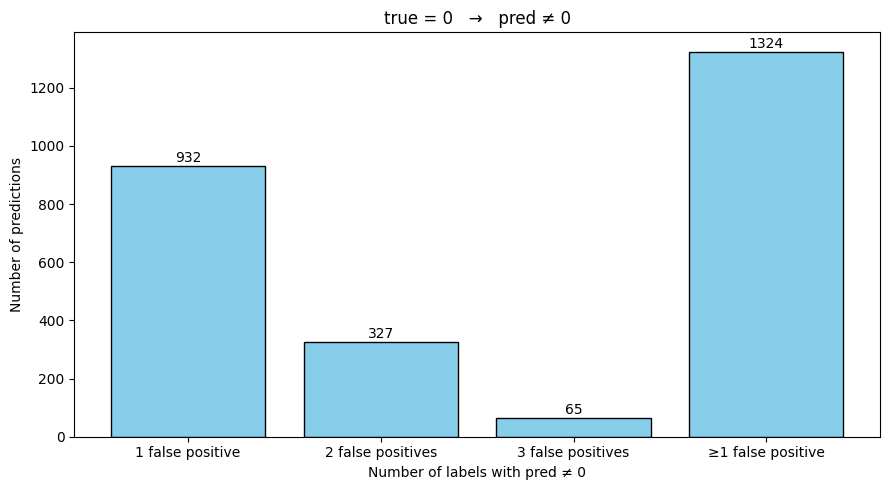

In [106]:
# ========================================
# true = 0   →   pred ≠ 0
# ========================================


import os
import pandas as pd
import matplotlib.pyplot as plt

# 1. Path to the folder containing both CSVs
FOLDER_PATH = r"C:\Users\Gleb\Desktop\N.L.P"

# 2. Filenames
ZERO_SHOT_FILE    = os.path.join(FOLDER_PATH, "GPT4O_ZERO_SHOT_LABELING_batch_3500.csv")
GROUND_TRUTH_FILE = os.path.join(FOLDER_PATH, "CHATGPT_DATASET.csv")

# 3. Read both CSVs (try UTF-8, then Latin1 if decoding fails)
def read_csv_either(path):
    try:
        return pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="latin1")

df_zero = read_csv_either(ZERO_SHOT_FILE)
df_true = read_csv_either(GROUND_TRUTH_FILE)

# 4. Define column names
COMMENT_COLUMN = "review"
label_columns  = ["difficulty", "interest", "usefulness", "teaching_quality"]

# 5. Merge on 'review'
df = pd.merge(
    df_zero,
    df_true[[COMMENT_COLUMN] + label_columns],
    on=COMMENT_COLUMN,
    how="inner",
    suffixes=("_pred", "_true")
)

# 6. For each row, count how many labels are false positives:
#    (true_val == 0 but pred_val != 0)
def count_false_positives(row):
    return sum(
        (row[f"{lab}_true"] == 0) and (row[f"{lab}_pred"] != 0)
        for lab in label_columns
    )

df["false_positive_count"] = df.apply(count_false_positives, axis=1)

# 7. Filter rows where there is at least one false positive
df_fp = df[df["false_positive_count"] > 0].copy()

# 8. Count how many responses have exactly 1, exactly 2, and exactly 3 false positives
exact_counts = df_fp["false_positive_count"].value_counts().sort_index()
for k in [1, 2, 3]:
    if k not in exact_counts:
        exact_counts[k] = 0
exact_counts = exact_counts.sort_index()  # index: 1,2,3

# 9. Compute total number of responses with ≥1 false positive
total_fp = len(df_fp)

# 10. Prepare labels and values for the bar chart
labels = ["1 false positive", "2 false positives", "3 false positives", "≥1 false positive"]
values = [exact_counts[1], exact_counts[2], exact_counts[3], total_fp]

# 11. Before plotting, print a full description for each category

print(f"\n\n1) Exactly one label was a false positive (true=0 but pred≠0): {exact_counts[1]} reviews")
print(f"   - In these reviews, exactly one of the four labels was incorrectly predicted as non-zero when it should have been 0.")
print(f"2) Exactly two labels were false positives: {exact_counts[2]} reviews")
print(f"   - In these reviews, two out of four labels were incorrectly predicted as non-zero when they should have been 0.")
print(f"3) Exactly three labels were false positives: {exact_counts[3]} reviews")
print(f"   - In these reviews, three out of four labels were incorrectly predicted as non-zero when they should have been 0.")
print(f"4) Total reviews with at least one false positive: {total_fp} reviews")
print(f"   - This is the sum of all reviews where any label was predicted non-zero despite the true value being 0.\n")

# 12. Plot histogram (bar chart) with the extra bar
plt.figure(figsize=(9, 5))
bars = plt.bar(labels, values, color="skyblue", edgecolor="black")
plt.xlabel("Number of labels with pred ≠ 0")
plt.ylabel("Number of predictions")
plt.title("true = 0   →   pred ≠ 0")

# Annotate each bar with its count
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        str(int(height)),
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


Detailed False-Negative Breakdown:
1) Exactly one false-negative label (true ≠ 0 but pred = 0): 204 reviews
   - In these reviews, exactly one out of four labels was incorrectly predicted as 0 when it should have been non-zero.
2) Exactly two false-negative labels: 2 reviews
   - In these reviews, two out of four labels were predicted as 0 despite true values being 1–3.
3) Exactly three false-negative labels: 0 reviews
   - In these reviews, three out of four labels were predicted as 0 despite true values being 1–3.
4) Total reviews with at least one false negative: 206 reviews
   - This is the sum of all reviews where any label was predicted as 0 although the true value was non-zero.



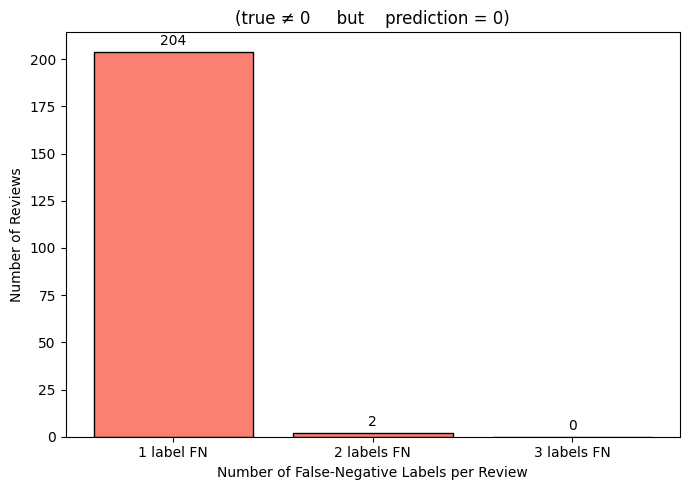

In [111]:
# ========================================
# true ≠ 0     but    prediction = 0
# ========================================



import os
import pandas as pd
import matplotlib.pyplot as plt

# 1. Path to the folder containing both CSVs
FOLDER_PATH = r"C:\Users\Gleb\Desktop\N.L.P"

# 2. Filenames (update names if they differ)
ZERO_SHOT_FILE    = os.path.join(FOLDER_PATH, "GPT4O_ZERO_SHOT_LABELING_batch_3500.csv")
GROUND_TRUTH_FILE = os.path.join(FOLDER_PATH, "CHATGPT_DATASET.csv")

# 3. Read both CSVs (try UTF-8, then Latin1 if decoding fails)
def read_csv_either(path):
    try:
        return pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="latin1")

df_zero = read_csv_either(ZERO_SHOT_FILE)
df_true = read_csv_either(GROUND_TRUTH_FILE)

# 4. Define column names for labels
COMMENT_COLUMN = "review"
label_columns  = ["difficulty", "interest", "usefulness", "teaching_quality"]

# 5. Merge on 'review'
df = pd.merge(
    df_zero,
    df_true[[COMMENT_COLUMN] + label_columns],
    on=COMMENT_COLUMN,
    how="inner",
    suffixes=("_pred", "_true")
)

# 6. Function to count false negatives in a row:
#    (true ≠ 0 but pred = 0)
def count_false_negatives(row):
    return sum(
        (row[f"{lab}_true"] != 0) and (row[f"{lab}_pred"] == 0)
        for lab in label_columns
    )

# 7. Apply to entire DataFrame
df["false_negative_count"] = df.apply(count_false_negatives, axis=1)

# 8. Filter only rows with at least one false negative
df_fn = df[df["false_negative_count"] > 0]

# 9. Compute distribution: how many rows have exactly 1, 2, or 3 false negatives
fn_counts = df_fn["false_negative_count"].value_counts().sort_index()
for k in [1, 2, 3]:
    if k not in fn_counts:
        fn_counts[k] = 0
fn_counts = fn_counts.sort_index()

# 10. Compute total number of responses with ≥1 false negative
total_fn = len(df_fn)

# 11. Before plotting, print a detailed breakdown
print("Detailed False-Negative Breakdown:")
print(f"1) Exactly one false-negative label (true ≠ 0 but pred = 0): {fn_counts[1]} reviews")
print(f"   - In these reviews, exactly one out of four labels was incorrectly predicted as 0 when it should have been non-zero.")
print(f"2) Exactly two false-negative labels: {fn_counts[2]} reviews")
print(f"   - In these reviews, two out of four labels were predicted as 0 despite true values being 1–3.")
print(f"3) Exactly three false-negative labels: {fn_counts[3]} reviews")
print(f"   - In these reviews, three out of four labels were predicted as 0 despite true values being 1–3.")
print(f"4) Total reviews with at least one false negative: {total_fn} reviews")
print(f"   - This is the sum of all reviews where any label was predicted as 0 although the true value was non-zero.\n")

# 12. Plot histogram (bar chart) of false-negative counts
plt.figure(figsize=(7, 5))
bars = plt.bar(
    ["1 label FN", "2 labels FN", "3 labels FN"],
    [fn_counts[1], fn_counts[2], fn_counts[3]],
    color="salmon",
    edgecolor="black"
)
plt.xlabel("Number of False-Negative Labels per Review")
plt.ylabel("Number of Reviews")
plt.title("(true ≠ 0     but    prediction = 0)")

# Annotate each bar with its count
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        str(int(height)),
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


Detailed Breakdown of Single-Label Prediction Errors (matches = 3):

1) 'True ≠ 0 → Pred = 0': 113 reviews
   - In these reviews, the true label was non-zero (1–3), but the model predicted 0.
2) 'True = 0 → Pred ≠ 0': 655 reviews
   - In these reviews, the true label was 0, but the model predicted a non-zero value (1–3).
3) 'True 1–3, |Pred−True| = 1': 112 reviews
   - In these reviews, the true label was in {1,2,3}, and the model’s prediction differed by exactly 1.
4) 'True 1–3, |Pred−True| = 2': 6 reviews
   - In these reviews, the true label was in {1,2,3}, and the model’s prediction differed by exactly 2.



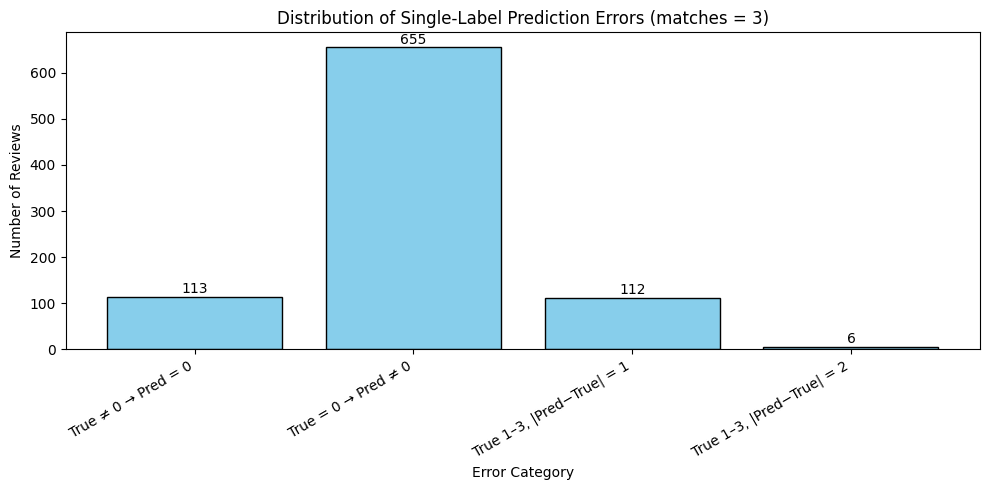

In [112]:
# =========================================================
# Exploration of review with only 3 exact matches out of 4
# =========================================================

import os
import pandas as pd
import matplotlib.pyplot as plt

# 1. Path to the folder containing both CSVs
FOLDER_PATH = r"C:\Users\Gleb\Desktop\N.L.P"

# 2. Filenames
ZERO_SHOT_FILE    = os.path.join(FOLDER_PATH, "GPT4O_ZERO_SHOT_LABELING_batch_3500.csv")
GROUND_TRUTH_FILE = os.path.join(FOLDER_PATH, "CHATGPT_DATASET.csv")

# 3. Read both CSVs (try UTF-8, then Latin1 if decoding fails)
def read_csv_either(path):
    try:
        return pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="latin1")

df_zero = read_csv_either(ZERO_SHOT_FILE)
df_true = read_csv_either(GROUND_TRUTH_FILE)

# 4. Verify column names and define label columns
COMMENT_COLUMN = "review"
label_columns  = ["difficulty", "interest", "usefulness", "teaching_quality"]

# 5. Merge on 'review'
df = pd.merge(
    df_zero,
    df_true[[COMMENT_COLUMN] + label_columns],
    on=COMMENT_COLUMN,
    how="inner",
    suffixes=("_pred", "_true")
)

# 6. Compute how many labels match (0–4)
def count_label_matches(row):
    return sum(row[f"{lab}_pred"] == row[f"{lab}_true"] for lab in label_columns)

df["matches"] = df.apply(count_label_matches, axis=1)

# 7. Filter rows where exactly 3 matched (1 label is wrong)
df_three = df[df["matches"] == 3].copy()

# 8. Initialize counters for each category (in English)
categories = {
    "True ≠ 0 → Pred = 0": 0,
    "True = 0 → Pred ≠ 0": 0,
    "True 1–3, |Pred−True| = 1": 0,
    "True 1–3, |Pred−True| = 2": 0
}

# 9. Loop through df_three, find the wrong label and categorize
for _, row in df_three.iterrows():
    for lab in label_columns:
        true_val = row[f"{lab}_true"]
        pred_val = row[f"{lab}_pred"]
        if pred_val != true_val:
            if true_val != 0 and pred_val == 0:
                categories["True ≠ 0 → Pred = 0"] += 1
            elif true_val == 0 and pred_val != 0:
                categories["True = 0 → Pred ≠ 0"] += 1
            elif true_val in [1, 2, 3]:
                diff = abs(pred_val - true_val)
                if diff == 1:
                    categories["True 1–3, |Pred−True| = 1"] += 1
                elif diff == 2:
                    categories["True 1–3, |Pred−True| = 2"] += 1
            break  # only one wrong label per row

# 10. Print detailed description for each category
print("Detailed Breakdown of Single-Label Prediction Errors (matches = 3):\n")
print(f"1) 'True ≠ 0 → Pred = 0': {categories['True ≠ 0 → Pred = 0']} reviews")
print("   - In these reviews, the true label was non-zero (1–3), but the model predicted 0.")
print(f"2) 'True = 0 → Pred ≠ 0': {categories['True = 0 → Pred ≠ 0']} reviews")
print("   - In these reviews, the true label was 0, but the model predicted a non-zero value (1–3).")
print(f"3) 'True 1–3, |Pred−True| = 1': {categories['True 1–3, |Pred−True| = 1']} reviews")
print("   - In these reviews, the true label was in {1,2,3}, and the model’s prediction differed by exactly 1.")
print(f"4) 'True 1–3, |Pred−True| = 2': {categories['True 1–3, |Pred−True| = 2']} reviews")
print("   - In these reviews, the true label was in {1,2,3}, and the model’s prediction differed by exactly 2.\n")

# 11. Plot histogram (bar chart) of the four categories in English
plt.figure(figsize=(10, 5))
bars = plt.bar(categories.keys(), categories.values(), color='skyblue', edgecolor='black')
plt.xlabel("Error Category")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Single-Label Prediction Errors (matches = 3)")
plt.xticks(rotation=30, ha='right')

# Annotate each bar with its count
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        str(int(height)),
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


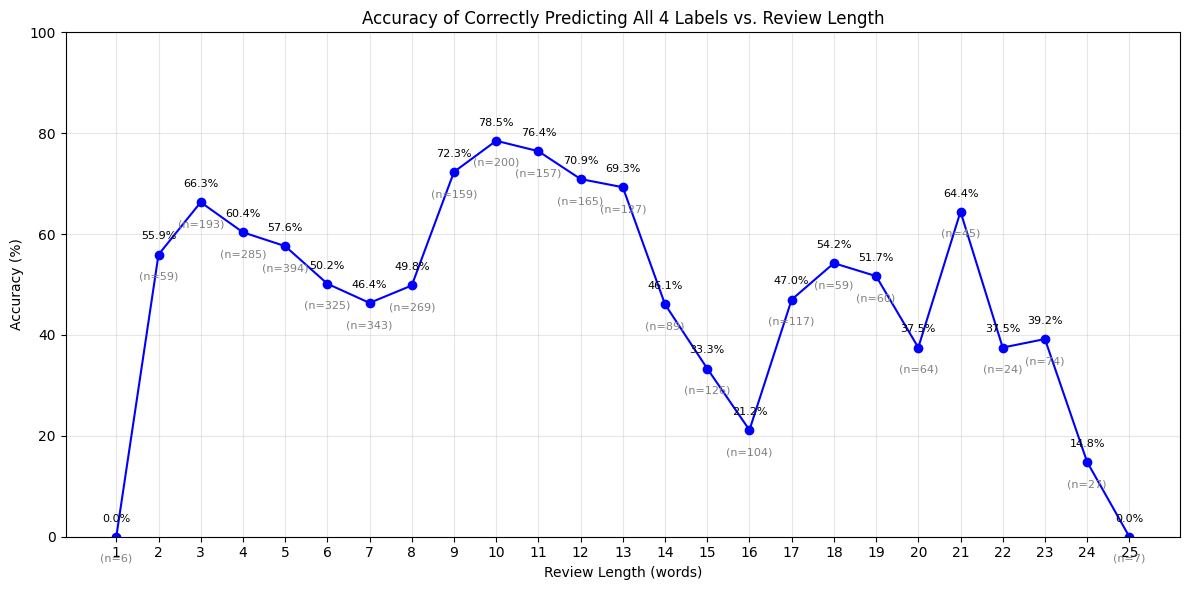

In [124]:
# ========================================
# Accuracy vs Review Length
# ========================================

import matplotlib.pyplot as plt
import pandas as pd

# Calculate review length (in words) and accuracy of all-4 correct
df['length'] = df['review'].apply(lambda txt: len(str(txt).split()))
df['all4_correct'] = (df['matches'] == 4).astype(int)

# Group by review length, calculate accuracy (%) and count
grouped = df.groupby('length').agg(
    accuracy=('all4_correct', 'mean'),
    count=('all4_correct', 'size')
).reset_index()

# Convert accuracy to percentage and limit length to 25 words
grouped['accuracy'] *= 100
grouped = grouped[grouped['length'] <= 25]

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(grouped['length'], grouped['accuracy'], marker='o', linestyle='-', color='blue')

# Annotate with accuracy (%) above and count (n) below each point
for x, acc, cnt in zip(grouped['length'], grouped['accuracy'], grouped['count']):
    plt.text(x, acc + 3, f'{acc:.1f}%', fontsize=8, ha='center', color='black')
    plt.text(x, acc - 5, f'(n={cnt})', fontsize=8, ha='center', color='gray')

plt.xlabel('Review Length (words)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Correctly Predicting All 4 Labels vs. Review Length')
plt.xticks(grouped['length'])
plt.ylim(0, 100)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [120]:
# ========================================
# Summarizing Results
# ========================================

import pandas as pd
from IPython.display import display, HTML

total_reviews = len(df)
accuracy_rows = []

# 1. Per-label accuracy
for lab in label_columns:
    correct = (df[f"{lab}_pred"] == df[f"{lab}_true"]).sum()
    pct     = correct / total_reviews * 100
    accuracy_rows.append({
        "Label": lab,
        "Correct": int(correct),
        "Total": total_reviews,
        "Accuracy (%)": round(pct, 2)
    })

# 2. Exactly 3-of-4 accuracy
exactly_3 = (df["matches"] == 3).sum()
pct_3     = exactly_3 / total_reviews * 100
accuracy_rows.append({
    "Label": "Exactly 3 of 4 labels",
    "Correct": int(exactly_3),
    "Total": total_reviews,
    "Accuracy (%)": round(pct_3, 2)
})

# 3. Overall all-4-label accuracy
all4_correct = (df["matches"] == 4).sum()
all4_pct     = all4_correct / total_reviews * 100
accuracy_rows.append({
    "Label": "Exactly 4 of 4 labels",
    "Correct": int(all4_correct),
    "Total": total_reviews,
    "Accuracy (%)": round(all4_pct, 2)
})

accuracy_df = pd.DataFrame(accuracy_rows)

print("\nPer-Label, Exactly-3-of-4, and All-4-Label Accuracy:\n")
display(HTML(accuracy_df.to_html(index=False)))



Per-Label, Exactly-3-of-4, and All-4-Label Accuracy:



Label,Correct,Total,Accuracy (%)
difficulty,3063,3510,87.26
interest,2823,3510,80.43
usefulness,2625,3510,74.79
teaching_quality,3093,3510,88.12
Exactly 3 of 4 labels,886,3510,25.24
Exactly 4 of 4 labels,1942,3510,55.33
